In this notebook, we are going to see an example of Clustering (K-means) and dimensionality reduction (PCA) on a water quality dataset from MM's Case dell'acqua.

In [410]:
import os
import pandas as pd
import numpy as np
import random

from IPython.display import display, HTML

In [411]:
# for reproducibility
np.random.seed(42)
random.seed(42)

In [412]:
from warnings import filterwarnings
filterwarnings('ignore')

# Load Data

In [413]:
# define data path
data_path = 'data'

In [414]:
# load the data
grab_df = pd.read_excel(os.path.join(data_path, 'grab.xlsx'))

In [415]:
# the dataset has two columns related to each parameter, one for the measurement 
# and one for the label related to the measurement, which can be:
# - "Normal": the measurement has a valid value
# - "Less than": the measurement is less than the LOQ
# - "NaN": the measurement is missing

grab_df

,Code,DateTime,Nitrate (mg/L),Temperature (°C),Color (CU),pH,Free Chlorine (mg/L),Conductivity (uS/cm),Turbidity (NTU),TOC (mg/L),...,Pseudomonas aeruginosa (UFC/250 mL)_label,Batteri coliformi a 37°C (MPN/100 mL)_label,Conta delle colonie a 22°C (UFC/mL)_label,Acido Perfluoroottansolfonico PFOS (µg/L)_label,Somma di PFAS (µg/L)_label,Cloroformio (µg/L)_label,Colony count at 30°C (UFC/mL),Colony count at 37°C (UFC/mL),Conteggio colonie a 30°C (UFC/mL)_label,Conta delle colonie a 37°C (UFC/mL)_label
0,Prealpi,2020-12-10,30.0,8.9,0.42,7.6,0.02,472.0,0.15,NaN,...,Less than,Normal,Less than,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Tognazzi,2021-01-12,31.0,10.6,0.03,7.2,0.05,712.0,0.40,NaN,...,NaN,Normal,Less than,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Tabacchi,2021-01-26,24.0,10.8,0.69,7.3,0.02,556.0,0.15,NaN,...,NaN,Normal,Less than,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Prealpi,2021-03-10,NaN,7.1,NaN,NaN,0.02,NaN,NaN,NaN,...,Less than,Normal,Less than,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Bande Nere,2021-04-15,NaN,12.9,NaN,NaN,0.02,NaN,NaN,NaN,...,Less than,Normal,Less than,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,Prealpi,2024-08-22,32.0,19.6,1.00,7.5,0.04,437.0,0.60,0.160,...,Less than,Normal,Normal,Less than,Less than,Normal,NaN,NaN,NaN,NaN
201,Fortunato,2024-08-26,31.2,17.3,2.70,7.3,0.02,612.0,0.30,0.360,...,Less than,Normal,Less than,Less than,Less than,Normal,NaN,NaN,NaN,NaN
202,Montevideo,2024-08-27,NaN,24.2,0.50,7.3,0.02,489.0,0.27,0.223,...,Less than,Normal,NaN,NaN,NaN,Normal,NaN,NaN,NaN,NaN
203,Tognazzi,2024-08-27,29.7,20.7,0.50,7.3,0.09,691.0,0.15,2.540,...,Less than,Normal,Normal,Less than,Normal,Normal,NaN,NaN,NaN,NaN


In [416]:
# since the label columns have the name in italian, we will rename them in english
feature_mapping = {
    "Cloro residuo libero (al prelievo) (mg/L di Cl2)": "Free Chlorine (mg/L)",
    "Colore (Cu)": "Color (CU)",
    "Concentrazione ioni idrogeno (unità pH)": "pH",
    "Conduttività a 20°C (µS/cm)": "Conductivity (uS/cm)",
    "TOC - carbonio organico totale (mg/L di C)": "TOC (mg/L)",
    "Temperatura (al prelievo) (°C)": "Temperature (°C)",
    "Torbidità (NTu)": "Turbidity (NTU)",
    "Nitrati (mg/L)": "Nitrate (mg/L)",
}

targets_mapping = {
    "Batteri coliformi a 37°C (MPN/100 mL)": "Coliforms (MPN/100mL)",
    "Bromodiclorometano (µg/L)": "Bromodichloromethane (µg/L)",
    "Bromoformio (µg/L)": "Bromoform (µg/L)",
    "Cloroformio (µg/L)": "Chloroform (µg/L)",
    "Conta delle colonie a 22°C (UFC/mL)": "Colony count at 22°C (UFC/mL)",
    "Conteggio colonie a 30°C (UFC/mL)": "Colony count at 30°C (UFC/mL)",
    "Conta delle colonie a 37°C (UFC/mL)": "Colony count at 37°C (UFC/mL)",
    "Dibromoclorometano (µg/L)": "Dibromochloromethane (µg/L)",
    "Enterococchi (MPN/100 mL)": "Enterococci (MPN/100mL)",
    "Escherichia coli (MPN/100 mL)": "Escherichia coli (MPN/100mL)",
    "Pseudomonas aeruginosa (UFC/250 mL)": "Pseudomonas aeruginosa (UFC/250mL)",
    "Acido Perfluoroottanoico PFOA (µg/L)": "Perfluorooctanoic acid PFOA (µg/L)",
    "Acido Perfluoroottansolfonico PFOS (µg/L)": "Perfluorooctanesulfonic acid PFOS (µg/L)",
    "Somma di PFAS (µg/L)": "Sum of PFAS (µg/L)",
}

In [417]:
from operator import contains

# rename the label columns
for column in grab_df.columns:
    if contains(column, "label"):
        variable_name = column.split("_")[0]

        if variable_name in feature_mapping:
            new_name = feature_mapping[variable_name]
            new_name = new_name + "_" + column.split("_")[1]
            grab_df.rename(columns={column: new_name}, inplace=True)

        if variable_name in targets_mapping:
            new_name = targets_mapping[variable_name]
            new_name = new_name + "_" + column.split("_")[1]
            grab_df.rename(columns={column: new_name}, inplace=True)

In [418]:
# the target variables that we are going to use are THMs
thms_columns = [
    'Bromodichloromethane (µg/L)',
    'Bromoform (µg/L)',
    'Chloroform (µg/L)',
    'Dibromochloromethane (µg/L)'
]

# Data Summary

In [419]:
# create a dataframe to store the summary of the data
info_df  = pd.DataFrame(
    columns=pd.MultiIndex.from_product(
        [
            list(feature_mapping.values()) + list(targets_mapping.values()),
            [
                "N° Entries",
                "N° Valid Samples",
                "% Missing",
                "N° < LOQ",
                "Mean Valid",
                "Std Valid",
                "LOQ values",
                "Start Date",
                "End Date",
            ],
        ]
    ),
    index=grab_df["Code"].unique(),
)

In [420]:
# compute the summary of the data
for code in grab_df["Code"].unique():
    for feature in list(feature_mapping.values()) + list(targets_mapping.values()):
        df = grab_df[grab_df["Code"] == code][
            ["DateTime", feature, feature + "_label"]
        ].copy()

        if df.dropna().shape[0] == 0:
            continue

        df["DateTime"] = pd.to_datetime(df["DateTime"])

        start_date = df.dropna()["DateTime"].min().strftime("%Y-%m-%d")
        end_date = df.dropna()["DateTime"].max().strftime("%Y-%m-%d")

        df = df[(df["DateTime"] >= start_date) & (df["DateTime"] <= end_date)]

        missing_values = (
            df[df[feature + "_label"].isna()].shape[0] / df.shape[0] * 100
        )

        info_df.loc[code, (feature, "N° Entries")] = df.shape[0]

        info_df.loc[code, (feature, "% Missing")] = round(missing_values, 2)

        info_df.loc[code, (feature, "N° < LOQ")] = df[
            df[feature + "_label"] == "Less than"
        ].shape[0]
        
        
        valid_df = df[df[feature + "_label"] == "Normal"]
        loq_df = df[df[feature + "_label"] == "Less than"]
        
        info_df.loc[code, (feature, "N° Valid Samples")] = valid_df.shape[0]
        info_df.loc[code, (feature, "N° < LOQ")] = loq_df.shape[0]
        

        info_df.loc[code, (feature, "Mean Valid")] = round(valid_df[feature].mean(), 2)
        info_df.loc[code, (feature, "Std Valid")] = round(valid_df[feature].std(), 2)
        
        loq_values = loq_df[feature].unique() * 2
        loq_values = [str(value) for value in loq_values]
        info_df.loc[code, (feature, "LOQ values")] = ", ".join(loq_values)

        info_df.loc[code, (feature, "Start Date")] = start_date
        info_df.loc[code, (feature, "End Date")] = end_date

In [421]:
info_df.sort_index(inplace=True)

In [422]:
# sort the first level of the columns and maintain the order of the second level
info_df = info_df.sort_index(axis=1, level=0, sort_remaining=False, key=lambda x: x.str.lower())

In [423]:
display(HTML(info_df.to_html()))

# Data Imputation

We can see that there are parameters that have a lot of missing values, and some of them have a lot of <LOQ values.

We are going to perform two types of imputation:
- for the parameters that have measurements below the LOQ, we will impute the missing values with the LOQ/2
- for the parameters that have NaN values, we will impute them through [MICE](https://miceforest.readthedocs.io/en/latest/) (Multiple Imputation by Chained Equations). 

MICE ‘fills in’ (imputes) missing data in a dataset through an iterative series of predictive models. In each iteration, each specified variable in the dataset is imputed using the other variables in the dataset. These iterations should be run until it appears that convergence has been met.

Keep in mind that we can only impute the input variables, not the target ones because we would introduce bias and misinformation in the dataset.


In [424]:
# define a function to replace the LOQ values with the LOQ/2
def replace_loq(row, column):
    return row[column] if row[column + "_label"] != "Less than" else row[column] / 2

In [425]:
# get the columns that contain 'label'
label_columns = [col for col in grab_df.columns if 'label' in col]

In [426]:
for column in grab_df.columns.difference(["Code", "DateTime"] + label_columns):
    grab_df[column] = grab_df.apply(
        lambda row: replace_loq(row, column), axis=1
    )

In [427]:
# remove the label columns
grab_df = grab_df.drop(columns=label_columns)

In [428]:
# keep only the columns we are interested in
grab_df = grab_df[["DateTime", "Code"] + list(feature_mapping.values()) + thms_columns]

In [429]:
grab_df

,DateTime,Code,Free Chlorine (mg/L),Color (CU),pH,Conductivity (uS/cm),TOC (mg/L),Temperature (°C),Turbidity (NTU),Nitrate (mg/L),Bromodichloromethane (µg/L),Bromoform (µg/L),Chloroform (µg/L),Dibromochloromethane (µg/L)
0,2020-12-10,Prealpi,0.01,0.42,7.6,472.0,NaN,8.9,0.075,30.0,NaN,NaN,NaN,NaN
1,2021-01-12,Tognazzi,0.05,0.03,7.2,712.0,NaN,10.6,0.400,31.0,NaN,NaN,NaN,NaN
2,2021-01-26,Tabacchi,0.01,0.69,7.3,556.0,NaN,10.8,0.075,24.0,NaN,NaN,NaN,NaN
3,2021-03-10,Prealpi,0.01,NaN,NaN,NaN,NaN,7.1,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-04-15,Bande Nere,0.01,NaN,NaN,NaN,NaN,12.9,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,2024-08-22,Prealpi,0.04,1.00,7.5,437.0,0.160,19.6,0.600,32.0,0.05,0.9,4.7,0.05
201,2024-08-26,Fortunato,0.01,2.70,7.3,612.0,0.360,17.3,0.300,31.2,0.05,1.0,2.7,0.05
202,2024-08-27,Montevideo,0.01,0.25,7.3,489.0,0.223,24.2,0.270,NaN,0.05,0.8,5.1,0.05
203,2024-08-27,Tognazzi,0.09,0.25,7.3,691.0,2.540,20.7,0.075,29.7,0.05,1.7,0.4,0.20


Now that we set the LOQ values to the valid measurements, we can impute the missing values.

In [430]:
input_df = grab_df[list(feature_mapping.values()) + ['DateTime'] + ['Code']].copy()

In [431]:
# check if there are rows with all NaN

for code in grab_df["Code"].unique():
    if input_df[input_df['Code'] == code].isnull().all(axis=1).sum() > 0: # Rows with all NaN
        print(f'{code} has {input_df[input_df["Code"] == code].isnull().all(axis=1).sum()} rows with all NaN')

No rows with all NaN

In [432]:
# check if there are columns with all NaN
for code in grab_df["Code"].unique():
    if input_df[input_df['Code'] == code].isnull().all(axis=0).sum() > 0: # Columns with all NaN
        print(f'{code} has {input_df[input_df["Code"] == code].isnull().all(axis=0).sum()} columns with all NaN')

No columns with all NaN

In [433]:
for code in grab_df["Code"].unique():
    if input_df[input_df['Code'] == code]['Turbidity (NTU)'].isnull().sum() > 0:
        print(f'{code} has {input_df[input_df["Code"] == code]["Turbidity (NTU)"].isnull().sum()} NaN values for Turbidity (NTU)')

Prealpi has 14 NaN values for Turbidity (NTU)
Tognazzi has 13 NaN values for Turbidity (NTU)
Tabacchi has 14 NaN values for Turbidity (NTU)
Bande Nere has 14 NaN values for Turbidity (NTU)
Berna has 14 NaN values for Turbidity (NTU)
Fortunato has 11 NaN values for Turbidity (NTU)
Gramsci has 12 NaN values for Turbidity (NTU)
Montevideo has 13 NaN values for Turbidity (NTU)
Chiostergi has 13 NaN values for Turbidity (NTU)


In [434]:
# drop the turbidity since it has a lot of missing values and the sensors are not well calibrated
input_df.drop(columns=['Turbidity (NTU)'], inplace=True)

feature_mapping.pop('Torbidità (NTu)')

'Turbidity (NTU)'

In [435]:
# in order to impute the missing values, we need to convert the datetime column to a float
# and the code column to a category
input_df['DateTime'] = pd.to_numeric(input_df['DateTime'])
input_df['Code'] = input_df['Code'].astype('category')

input_df = input_df.reset_index(drop=True)

In [436]:
import miceforest as mf

In [437]:
# create a kernel dataset, able to perform MICE on itself
kernel = mf.ImputationKernel(
    data=input_df,
    variable_schema=input_df.columns.difference(['DateTime', 'Code']).to_list(),
    random_state=42,
    mean_match_strategy='shap',
)

kernel.mice(5, verbose=True)

Initialized logger with name MICE Iterations 1 - 5 and 4 levels
1 Dataset 0
 | Nitrate (mg/L) | Color (CU) | Conductivity (uS/cm) | pH | Free Chlorine (mg/L) | Temperature (°C) | TOC (mg/L)
2 Dataset 0
 | Nitrate (mg/L) | Color (CU) | Conductivity (uS/cm) | pH | Free Chlorine (mg/L) | Temperature (°C) | TOC (mg/L)
3 Dataset 0
 | Nitrate (mg/L) | Color (CU) | Conductivity (uS/cm) | pH | Free Chlorine (mg/L) | Temperature (°C) | TOC (mg/L)
4 Dataset 0
 | Nitrate (mg/L) | Color (CU) | Conductivity (uS/cm) | pH | Free Chlorine (mg/L) | Temperature (°C) | TOC (mg/L)
5 Dataset 0
 | Nitrate (mg/L) | Color (CU) | Conductivity (uS/cm) | pH | Free Chlorine (mg/L) | Temperature (°C) | TOC (mg/L)


In [438]:
# get the completed dataset
completed_dataset = kernel.complete_data(dataset=0)

In [439]:
completed_dataset

,Free Chlorine (mg/L),Color (CU),pH,Conductivity (uS/cm),TOC (mg/L),Temperature (°C),Nitrate (mg/L),DateTime,Code
0,0.01,0.42,7.6,472.0,0.200,8.9,30.0,1607558400000000000,Prealpi
1,0.05,0.03,7.2,712.0,0.500,10.6,31.0,1610409600000000000,Tognazzi
2,0.01,0.69,7.3,556.0,0.270,10.8,24.0,1611619200000000000,Tabacchi
3,0.01,0.25,7.3,492.0,0.200,7.1,29.7,1615334400000000000,Prealpi
4,0.01,0.25,7.3,698.0,0.387,12.9,21.9,1618444800000000000,Bande Nere
...,...,...,...,...,...,...,...,...,...
200,0.04,1.00,7.5,437.0,0.160,19.6,32.0,1724284800000000000,Prealpi
201,0.01,2.70,7.3,612.0,0.360,17.3,31.2,1724630400000000000,Fortunato
202,0.01,0.25,7.3,489.0,0.223,24.2,23.6,1724716800000000000,Montevideo
203,0.09,0.25,7.3,691.0,2.540,20.7,29.7,1724716800000000000,Tognazzi


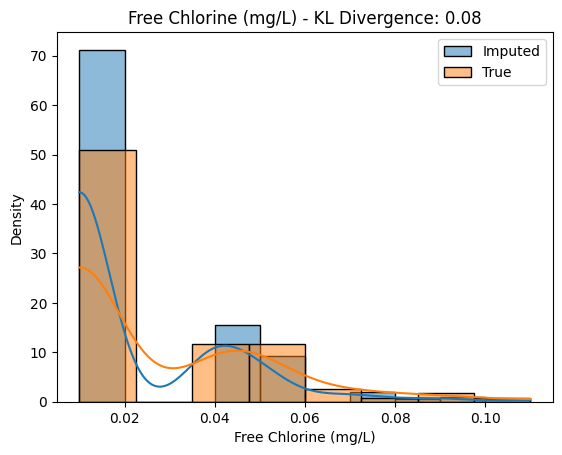

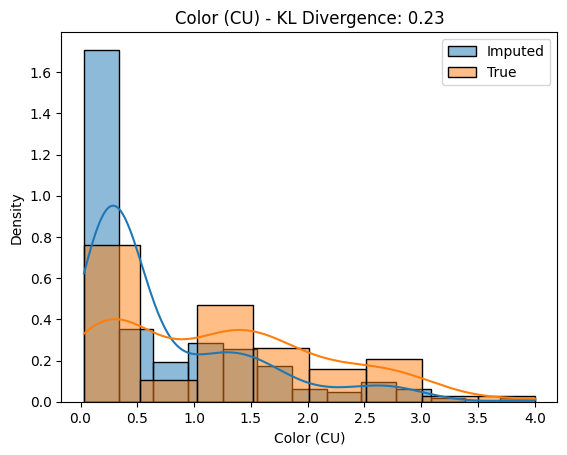

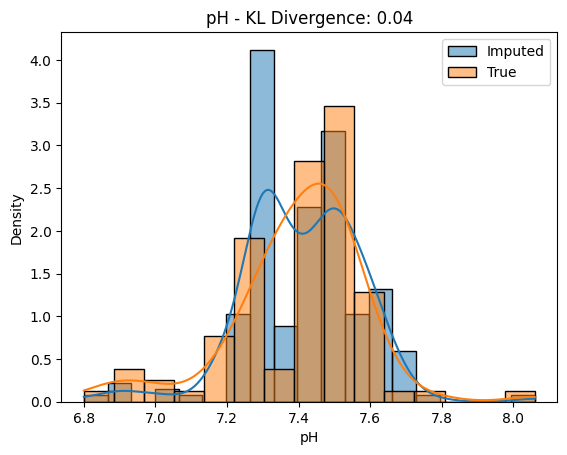

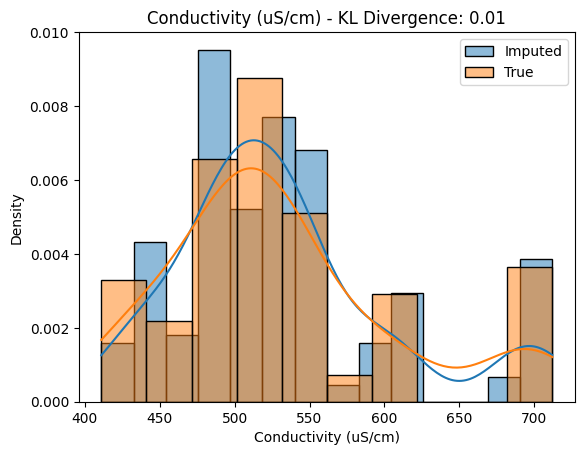

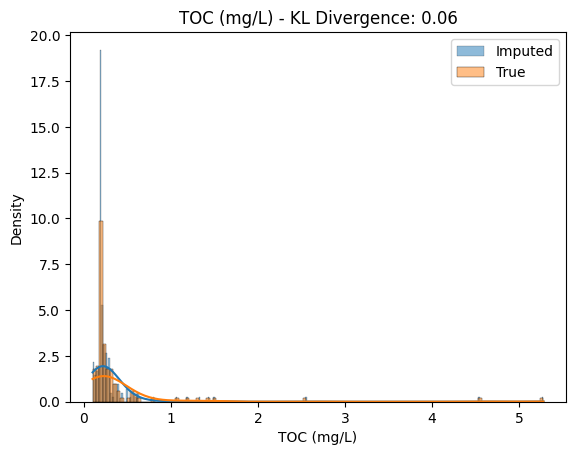

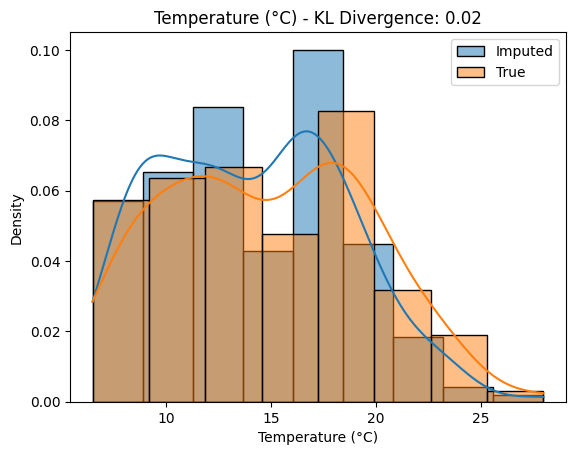

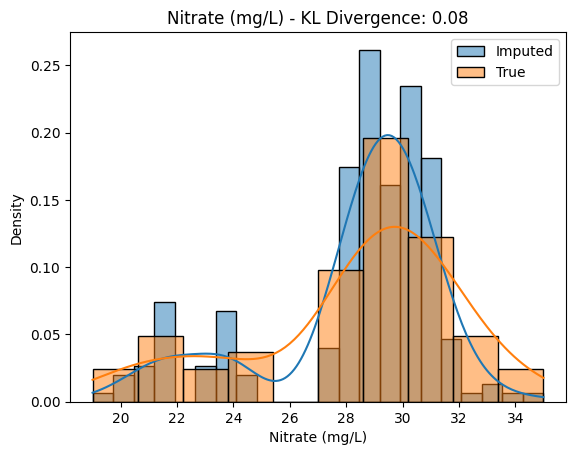

In [440]:
# check if the distribution of the imputed values is similar to the distribution of the true values
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, entropy

for feature in feature_mapping.values():
    sns.histplot(completed_dataset[feature], label='Imputed', kde=True, stat='density')
    sns.histplot(grab_df[feature], label='True', kde=True, stat='density')
    
    # compare the similarity of the distributions, keeping in mind that the non-imputed values are nan 
    # so we need to remove them from the comparison
    # First fit the distributions
    kde_completed = gaussian_kde(completed_dataset[feature])
    kde_grab = gaussian_kde(grab_df[feature].dropna())
    
    # create a grid of points to evaluate the distributions
    x_vals = np.linspace(min(completed_dataset[feature].min(), grab_df[feature].dropna().min()), max(completed_dataset[feature].max(), grab_df[feature].dropna().max()), 1000)
    kde_completed_vals = kde_completed.pdf(x_vals)
    kde_grab_vals = kde_grab.pdf(x_vals)
    
    # normalize the pdfs
    kde_completed_vals = kde_completed_vals / kde_completed_vals.sum()
    kde_grab_vals = kde_grab_vals / kde_grab_vals.sum()
    
    # compute the kl divergence between the imputed and the true values
    kl_div_value = entropy(kde_completed_vals, kde_grab_vals)
    
    plt.title(f'{feature} - KL Divergence: {kl_div_value:.2f}')
    plt.legend()
    plt.show()



All the distributions look similar. As a rule of thumb, if the KL divergence is less than 0.5, the distributions are considered similar

In [441]:
# add the thms columns
completed_dataset[thms_columns] = grab_df[thms_columns]

In [442]:
grab_df = completed_dataset

In [443]:
grab_df

,Free Chlorine (mg/L),Color (CU),pH,Conductivity (uS/cm),TOC (mg/L),Temperature (°C),Nitrate (mg/L),DateTime,Code,Bromodichloromethane (µg/L),Bromoform (µg/L),Chloroform (µg/L),Dibromochloromethane (µg/L)
0,0.01,0.42,7.6,472.0,0.200,8.9,30.0,1607558400000000000,Prealpi,NaN,NaN,NaN,NaN
1,0.05,0.03,7.2,712.0,0.500,10.6,31.0,1610409600000000000,Tognazzi,NaN,NaN,NaN,NaN
2,0.01,0.69,7.3,556.0,0.270,10.8,24.0,1611619200000000000,Tabacchi,NaN,NaN,NaN,NaN
3,0.01,0.25,7.3,492.0,0.200,7.1,29.7,1615334400000000000,Prealpi,NaN,NaN,NaN,NaN
4,0.01,0.25,7.3,698.0,0.387,12.9,21.9,1618444800000000000,Bande Nere,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,0.04,1.00,7.5,437.0,0.160,19.6,32.0,1724284800000000000,Prealpi,0.05,0.9,4.7,0.05
201,0.01,2.70,7.3,612.0,0.360,17.3,31.2,1724630400000000000,Fortunato,0.05,1.0,2.7,0.05
202,0.01,0.25,7.3,489.0,0.223,24.2,23.6,1724716800000000000,Montevideo,0.05,0.8,5.1,0.05
203,0.09,0.25,7.3,691.0,2.540,20.7,29.7,1724716800000000000,Tognazzi,0.05,1.7,0.4,0.20


In [444]:
# Unfortunatly, there are missing values in the thms columns, so we need to drop them
grab_df.dropna(subset=thms_columns, inplace=True)
grab_df.shape

(44, 13)

In [445]:
grab_df.reset_index(drop=True, inplace=True)

In [446]:
grab_df.head()

,Free Chlorine (mg/L),Color (CU),pH,Conductivity (uS/cm),TOC (mg/L),Temperature (°C),Nitrate (mg/L),DateTime,Code,Bromodichloromethane (µg/L),Bromoform (µg/L),Chloroform (µg/L),Dibromochloromethane (µg/L)
0,0.01,1.20,7.0,502.0,0.3,8.5,21.5,1706745600000000000,Bande Nere,0.05,1.3,0.7,0.05
1,0.01,1.50,6.9,482.0,0.2,11.8,28.7,1706745600000000000,Berna,0.05,1.1,0.9,0.05
2,0.07,1.20,6.8,443.0,0.2,12.0,29.4,1707091200000000000,Gramsci,0.05,1.8,9.2,0.30
3,0.06,0.25,6.9,482.0,0.1,12.0,33.6,1707264000000000000,Chiostergi,0.05,1.0,2.2,0.05
4,0.11,0.25,6.9,437.0,0.1,9.4,29.4,1707264000000000000,Prealpi,0.20,2.3,9.8,0.50


We now have a small amount of data, so it would be useful to cluster data points coming from different case dell'acqua.

# Clustering

We are going to use two clustering algorithms to cluster the data points coming from different case dell'acqua.

The first version is the hierarchical clustering, where we use the gower distance to cluster the data points.

The second version is constrained K-means, where we add the constraint that the data points coming from the same case dell'acqua must be in the same cluster.

Since K-means requires the number of clusters to be specified, we will use the different metrics to find the optimal number of clusters.
- intra-cluster variance weighted by the number of points in the cluster (the lower the better);
- silhouette score: how similar an object is to its own cluster (cohesion) compared to other clusters (separation) (the higher the better);
- davies-bouldin index: measures the average similarity between each cluster and the most similar cluster (the lower the better).

## Hierarchical Clustering

In [447]:
from scipy.cluster.hierarchy import linkage, dendrogram
from gower import gower_matrix

In [448]:
# remove the datetime column as it is not a feature and could wrongly bias the clustering
df = grab_df[grab_df.columns.difference(['DateTime'])]
df["Code"] = df["Code"].astype('str')

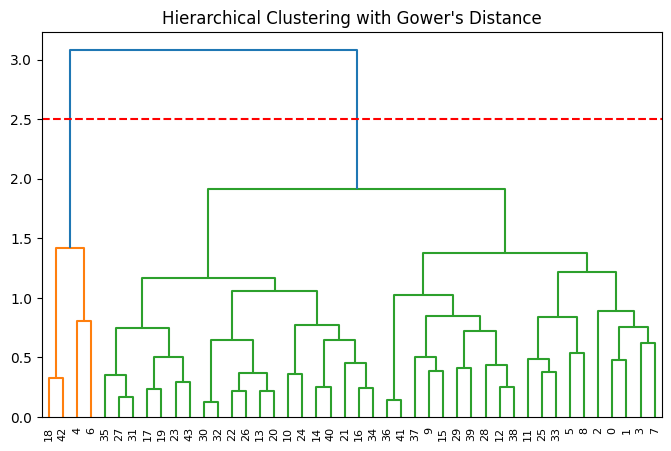

In [449]:
distance_matrix = gower_matrix(df)

# Perform hierarchical clustering
linkage_matrix = linkage(distance_matrix, method='ward')

# Plot dendrogram
plt.figure(figsize=(8, 5))
dendrogram(linkage_matrix, labels=df.index, leaf_rotation=90)

plt.axhline(y=2.5, color='r', linestyle='--')

plt.title("Hierarchical Clustering with Gower's Distance")
plt.show()

To find the optimal number of clusters by looking at the dendogram, you need to identify the longest vertical line that does not cross any horizontal lines. 

Draw a horizontal line through it and count the number of vertical lines it crosses. This number is an estimate of the optimal number of clusters.

So the number of clusters is 2. Let's validate it with the silhouette score.

In [450]:
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score
best_score = -1
best_k = 2

for k in range(2, 10): 
    clusters = fcluster(linkage_matrix, k, criterion='maxclust')
    score = silhouette_score(distance_matrix, clusters, metric='precomputed')
    print(f'Clusters: {k}, Silhouette Score: {score:.4f}')
    
    if score > best_score:
        best_score = score
        best_k = k
        
print(f'Best number of clusters: {best_k}')

Clusters: 2, Silhouette Score: 0.3409
Clusters: 3, Silhouette Score: 0.1027
Clusters: 4, Silhouette Score: 0.1300
Clusters: 5, Silhouette Score: 0.1292
Clusters: 6, Silhouette Score: 0.1263
Clusters: 7, Silhouette Score: 0.1344
Clusters: 8, Silhouette Score: 0.1437
Clusters: 9, Silhouette Score: 0.1732
Best number of clusters: 2


Let's see if the clusters are coherent with the case dell'acqua.

In [451]:
cluster0_indexes = [4, 6, 18, 42]
cluster1_indexes = grab_df.index.difference(cluster0_indexes)

In [452]:
cluster0_df = grab_df.iloc[cluster0_indexes]
cluster1_df = grab_df.iloc[cluster1_indexes]

In [453]:
cluster0_df

,Free Chlorine (mg/L),Color (CU),pH,Conductivity (uS/cm),TOC (mg/L),Temperature (°C),Nitrate (mg/L),DateTime,Code,Bromodichloromethane (µg/L),Bromoform (µg/L),Chloroform (µg/L),Dibromochloromethane (µg/L)
4,0.11,0.25,6.9,437.0,0.10,9.4,29.4,1707264000000000000,Prealpi,0.20,2.3,9.8,0.5
6,0.01,0.25,7.0,617.0,0.20,12.4,35.0,1707696000000000000,Fortunato,0.60,1.4,4.5,0.8
18,0.08,0.25,7.3,693.0,5.28,17.9,30.8,1717459200000000000,Tognazzi,0.05,2.1,0.5,0.3
42,0.09,0.25,7.3,691.0,2.54,20.7,29.7,1724716800000000000,Tognazzi,0.05,1.7,0.4,0.2


In [454]:
cluster1_df

,Free Chlorine (mg/L),Color (CU),pH,Conductivity (uS/cm),TOC (mg/L),Temperature (°C),Nitrate (mg/L),DateTime,Code,Bromodichloromethane (µg/L),Bromoform (µg/L),Chloroform (µg/L),Dibromochloromethane (µg/L)
0,0.01,1.20,7.0,502.0,0.300,8.5,21.5,1706745600000000000,Bande Nere,0.05,1.30,0.7,0.05
1,0.01,1.50,6.9,482.0,0.200,11.8,28.7,1706745600000000000,Berna,0.05,1.10,0.9,0.05
2,0.07,1.20,6.8,443.0,0.200,12.0,29.4,1707091200000000000,Gramsci,0.05,1.80,9.2,0.30
3,0.06,0.25,6.9,482.0,0.100,12.0,33.6,1707264000000000000,Chiostergi,0.05,1.00,2.2,0.05
5,0.05,3.00,7.2,515.0,0.200,13.7,27.8,1707350400000000000,Montevideo,0.05,1.80,5.0,0.30
7,0.01,0.25,7.1,691.0,0.200,12.9,30.6,1707782400000000000,Tognazzi,0.05,2.40,0.6,0.20
8,0.04,2.80,7.2,594.0,0.200,11.8,27.2,1708300800000000000,Tabacchi,0.05,3.20,3.0,0.30
9,0.04,0.25,7.2,550.0,0.300,11.6,30.1,1708905600000000000,Gramsci,0.05,1.20,6.8,0.05
10,0.05,1.20,7.2,547.0,0.500,13.8,30.0,1709164800000000000,Berna,0.05,1.40,1.2,0.20
11,0.07,1.80,7.3,504.0,0.400,13.5,20.6,1709164800000000000,Bande Nere,0.05,2.70,0.6,0.30


We can see that there are some points coming from the same case dell'acqua in both clusters, which is not what we want.

So we need to find a way to cluster the data points coming from the same case dell'acqua in the same cluster.

One way to do this is to use Constraint K-means, where we add the constraint that the data points coming from the same case dell'acqua must be in the same cluster.

In [455]:
# TODO fare anche K-means standard

## K-means

In [456]:
from sklearn.cluster import KMeans

In [457]:
# we need to drop also the code column as k-means is not able to handle categorical variables
df = grab_df[grab_df.columns.difference(['DateTime', 'Code'])]

In [458]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [459]:
from sklearn.metrics import davies_bouldin_score

variances = []
sil_scores = []
db_scores = []

# define the number of points
total_points = df.shape[0]

# compute the variance also for the case of 1 cluster
variance = np.var(df, axis=0).mean()

variances.append(variance)

for n_cluster in range(2, 10):
    kmeans = KMeans(n_clusters=n_cluster, random_state=12)
    clusters = kmeans.fit_predict(df)
    
    sil_score = silhouette_score(df, clusters)
    db_score = davies_bouldin_score(df, clusters)

    df['Cluster'] = clusters
    
    # compute the variance of each cluster
    variance = 0
    for cluster in df['Cluster'].unique():
        cluster_df = df[df['Cluster'] == cluster].copy()
        variance += np.var(cluster_df, axis=0).mean() * cluster_df.shape[0] / total_points
    
    # compute average variance for n_cluster
    variance /= n_cluster    
    
    variances.append(variance)
    sil_scores.append(sil_score)
    db_scores.append(db_score)
    
    df.drop(columns=['Cluster'], inplace=True)

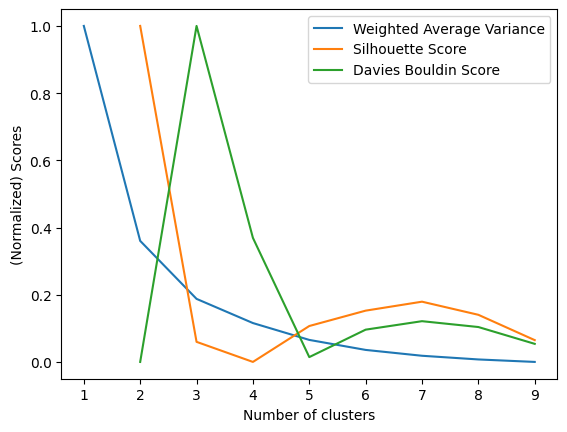

In [460]:
# normalize the scores
variances = np.array(variances)
sil_scores = np.array(sil_scores)
db_scores = np.array(db_scores)

variances = scaler.fit_transform(variances.reshape(-1, 1)).flatten()
sil_scores = scaler.fit_transform(sil_scores.reshape(-1, 1)).flatten()
db_scores = scaler.fit_transform(db_scores.reshape(-1, 1)).flatten()

plt.plot(range(1, 10), variances, label='Weighted Average Variance')
plt.plot(range(2, 10), sil_scores, label='Silhouette Score')
plt.plot(range(2, 10), db_scores, label='Davies Bouldin Score')


plt.xlabel('Number of clusters')
plt.ylabel('(Normalized) Scores')

plt.legend()

plt.show()

The optimal number of clusters is 2. Evaluate the clustering with similarity matrix inspection.

In [461]:
from seaborn import heatmap
from sklearn.metrics.pairwise import euclidean_distances

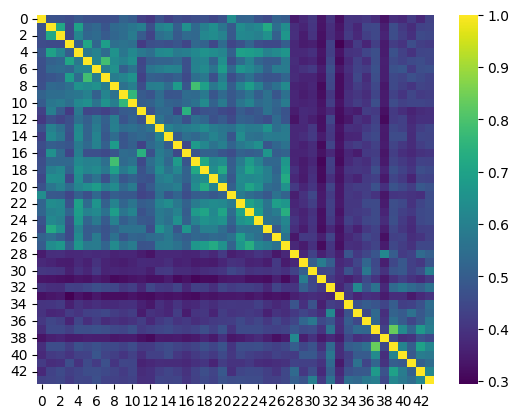

In [383]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(df)

clusters = kmeans.predict(df)
df['Cluster'] = clusters

distance_matrix = euclidean_distances(df)
similarity_matrix = 1 / (1 + distance_matrix)

sorted_indices = np.argsort(df['Cluster'])
sorted_matrix = similarity_matrix[sorted_indices, :][:, sorted_indices]

heatmap(sorted_matrix, cmap='viridis')
plt.show()


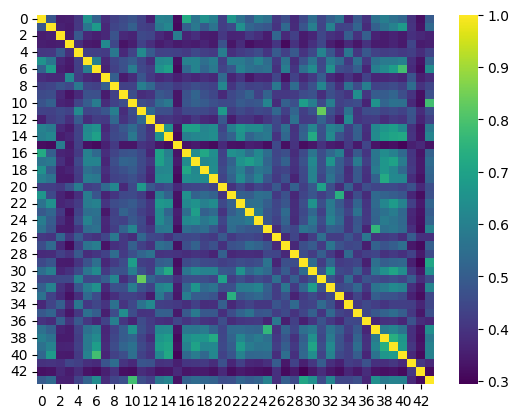

In [ ]:
distance_matrix = euclidean_distances(df)
similarity_matrix = 1 / (1 + distance_matrix)

sorted_indices = np.random.permutation(df.index)
sorted_matrix = similarity_matrix[sorted_indices, :][:, sorted_indices]

heatmap(sorted_matrix, cmap='viridis')
plt.show()


## COP K-means

In [384]:
from copkmeans.cop_kmeans import cop_kmeans 

In [385]:
# copy the dataframe
df = grab_df.copy()

In [386]:
# define the feature + thms columns
joint_columns = list(feature_mapping.values()) + thms_columns

In [387]:
# scale the data
scaler = MinMaxScaler()
df[joint_columns] = pd.DataFrame(scaler.fit_transform(df[joint_columns]), columns=joint_columns)

In [388]:
from itertools import combinations

# define a list of constraints, where every element is a list of the form [index1, index2]
# that means that the data points with the indexes index1 and index2 must be in the same cluster
must_link = []


for code in df['Code'].unique():
    # get all the pair combinations of the entries with same code to add to the must_link
    index_pairs = list(combinations(df[df['Code'] == code].index, 2)) 
    must_link.extend(index_pairs)

# convert the dataframe to a numpy array to pass it to the cop_kmeans function
np_df = df[joint_columns].to_numpy()

In [389]:
from sklearn.metrics import davies_bouldin_score

variances = []
sil_scores = []
db_scores = []

# compute the variance also for the case of 1 cluster
variance = np.var(np_df, axis=0).mean()

variances.append(variance)

# define the number of points
total_points = df.shape[0]

for n_cluster in range(2, 10):
    clusters, centers = cop_kmeans(np_df, n_cluster, ml=must_link)
    
    sil_score = silhouette_score(np_df, clusters)
    db_score = davies_bouldin_score(np_df, clusters)

    df['Cluster'] = clusters
    
    # compute the variance of each cluster
    variance = 0
    for cluster in df['Cluster'].unique():
        cluster_df = df[df['Cluster'] == cluster].copy()
        variance += np.var(cluster_df[joint_columns], axis=0).mean() * cluster_df.shape[0] / total_points
    
    # compute average variance for n_cluster
    variance /= n_cluster    
    
    variances.append(variance)
    sil_scores.append(sil_score)
    db_scores.append(db_score)
    
    df.drop(columns=['Cluster'], inplace=True)
    

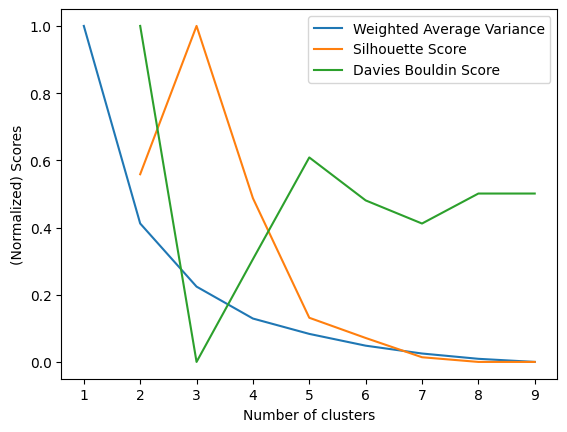

In [390]:
# normalize the scores
variances = np.array(variances)
sil_scores = np.array(sil_scores)
db_scores = np.array(db_scores)

variances = scaler.fit_transform(variances.reshape(-1, 1)).flatten()
sil_scores = scaler.fit_transform(sil_scores.reshape(-1, 1)).flatten()
db_scores = scaler.fit_transform(db_scores.reshape(-1, 1)).flatten()

plt.plot(range(1, 10), variances, label='Weighted Average Variance')
plt.plot(range(2, 10), sil_scores, label='Silhouette Score')
plt.plot(range(2, 10), db_scores, label='Davies Bouldin Score')


plt.xlabel('Number of clusters')
plt.ylabel('(Normalized) Scores')

plt.legend()

plt.show()

The silhouette score is the highest for 3 clusters, the davies-bouldin score is the lowest for 3 clusters. The weighted average variance would suggest 4 clusters, but all together the best number of clusters is 3.

In [391]:
n_clusters = 2

must_link = []


for code in df['Code'].unique():
    # get all the pair combinations of the entries with same code to add to the must_link
    index_pairs = list(combinations(df[df['Code'] == code].index, 2)) 
    must_link.extend(index_pairs)

np_df = df[joint_columns].to_numpy()

clusters, centers = cop_kmeans(np_df, n_clusters, ml=must_link,)

In [392]:
df['Cluster'] = clusters

In [393]:
for cluster in df['Cluster'].unique():
    print(f'Cluster {cluster}')
    codes = df[df['Cluster'] == cluster]['Code'].unique().tolist()
    
    print(codes)

Cluster 1
['Bande Nere', 'Tognazzi', 'Tabacchi']
Cluster 0
['Berna', 'Gramsci', 'Chiostergi', 'Prealpi', 'Montevideo', 'Fortunato']


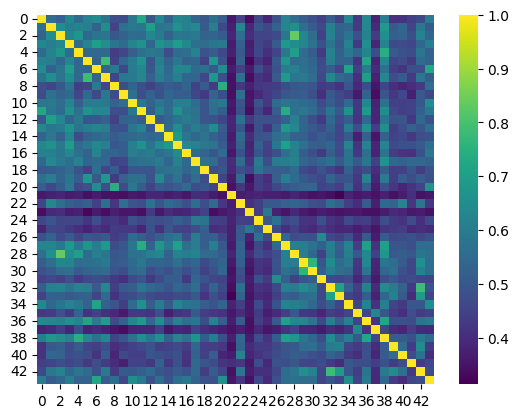

In [394]:
distance_matrix = euclidean_distances(df[joint_columns])
similarity_matrix = 1 / (1 + distance_matrix)

sorted_indices = np.argsort(df['Cluster'])
sorted_matrix = similarity_matrix[sorted_indices, :][:, sorted_indices]

heatmap(sorted_matrix, cmap='viridis')
plt.show()

In order to have a better visualization, we can try to perform clustering on a subset of the variables in the dataset.

However, in order to lose much less information, we can perform PCA on the dataset and then perform clustering on the principal components.

## COP K-means on Temperature, Free Chlorine and TTHMs

Let's try to perform clustering on the temperature, free chlorine and TTHMs.

In [493]:
grab_df['TTHMs'] = grab_df[thms_columns].sum(axis=1)

In [494]:
subset_columns = ['Temperature (°C)', 'Free Chlorine (mg/L)', 'TTHMs']

In [495]:
df = grab_df[subset_columns + ['Code']].copy()


In [496]:
# scale the data
scaler = MinMaxScaler()
df[subset_columns] = pd.DataFrame(scaler.fit_transform(df[subset_columns]), columns=subset_columns)

In [497]:
# define the must link
must_link = []

for code in df['Code'].unique():
    index_pairs = list(combinations(df[df['Code'] == code].index, 2)) 
    must_link.extend(index_pairs)

np_df = df[subset_columns].to_numpy()


In [498]:
variances = []
sil_scores = []
db_scores = []

# compute the variance also for the case of 1 cluster
variance = np.var(np_df, axis=0).mean()

variances.append(variance)

# define the number of points
total_points = df.shape[0]

for n_cluster in range(2, 10):
    clusters, centers = cop_kmeans(np_df, n_cluster, ml=must_link)
    
    sil_score = silhouette_score(np_df, clusters)
    db_score = davies_bouldin_score(np_df, clusters)

    df['Cluster'] = clusters
    
    # compute the variance of each cluster
    variance = 0
    for cluster in df['Cluster'].unique():
        cluster_df = df[df['Cluster'] == cluster].copy()
        variance += np.var(cluster_df[subset_columns], axis=0).mean() * cluster_df.shape[0] / total_points
    
    # compute average variance for n_cluster
    variance /= n_cluster    
    
    variances.append(variance)
    sil_scores.append(sil_score)
    db_scores.append(db_score)
    
    df.drop(columns=['Cluster'], inplace=True)

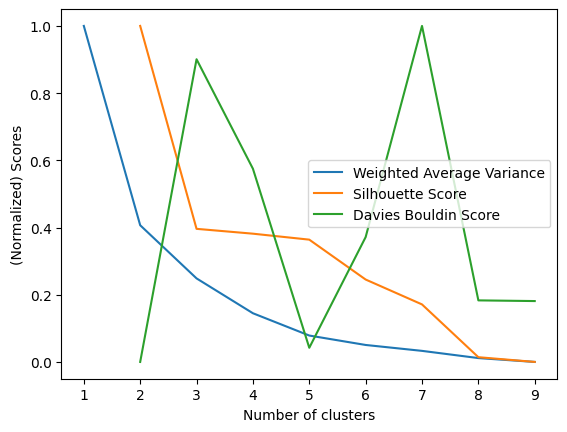

In [499]:
# normalize the scores
variances = np.array(variances)
sil_scores = np.array(sil_scores)
db_scores = np.array(db_scores)

variances = scaler.fit_transform(variances.reshape(-1, 1)).flatten()
sil_scores = scaler.fit_transform(sil_scores.reshape(-1, 1)).flatten()
db_scores = scaler.fit_transform(db_scores.reshape(-1, 1)).flatten()

plt.plot(range(1, 10), variances, label='Weighted Average Variance')
plt.plot(range(2, 10), sil_scores, label='Silhouette Score')
plt.plot(range(2, 10), db_scores, label='Davies Bouldin Score')


plt.xlabel('Number of clusters')
plt.ylabel('(Normalized) Scores')

plt.legend()
plt.show()

We select 2 as the number of clusters.

In [500]:
n_clusters = 2

must_link = []


for code in df['Code'].unique():
    # get all the pair combinations of the entries with same code to add to the must_link
    index_pairs = list(combinations(df[df['Code'] == code].index, 2)) 
    must_link.extend(index_pairs)

np_df = df[subset_columns].to_numpy()

clusters, centers = cop_kmeans(np_df, n_clusters, ml=must_link,)

In [501]:
df['Cluster'] = clusters

In [502]:
for cluster in df['Cluster'].unique():
    print(f'Cluster {cluster}')
    codes = df[df['Cluster'] == cluster]['Code'].unique().tolist()
    
    print(codes)

Cluster 0
['Bande Nere', 'Berna', 'Chiostergi', 'Tognazzi']
Cluster 1
['Gramsci', 'Prealpi', 'Montevideo', 'Fortunato', 'Tabacchi']


In [510]:
# plot the clusters in a 3D scatter plot with plotly
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Scatter3d(
        x=df[df['Cluster'] == cluster]['Temperature (°C)'],
        y=df[df['Cluster'] == cluster]['Free Chlorine (mg/L)'],
        z=df[df['Cluster'] == cluster]['TTHMs'],
        mode='markers',
        name=f'Cluster {cluster}',
        marker=dict(size=5), 
    ) for cluster in df['Cluster'].unique()
])

fig.update_layout(
    scene=dict(
        xaxis_title='Temperature (°C)',
        yaxis_title='Free Chlorine (mg/L)', 
        zaxis_title='TTHMs'
    ),
    showlegend=True
)

fig.show(
    width=800,
    height=600
)


# PCA

Principal Component Analysis is a technique that allows us to reduce the dimensionality of the dataset by projecting the data onto a lower-dimensional space. It can also be used as a model selection technique to select the most important features.

We are to use PCA in a supervised way, by trying to predict the TTHMs from the other variables.

We are going to compare three different approaches:
- Linear Regression with all the variables
- Linear Regression with 2 input variables based on expert knowledge (temperature and free chlorine)
- Linear Regression with the principal components

We are going to use the principal components as features for the Linear Regression.

Comparison is done with cross-validation.

In [406]:
# import the necessary libraries
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [407]:
# All the variables
df = grab_df[list(feature_mapping.values()) + thms_columns].copy()
df['TTHMs'] = df[thms_columns].sum(axis=1)
df = df[list(feature_mapping.values()) + ['TTHMs']]

# scale the data
scaler = MinMaxScaler()
df[list(feature_mapping.values())] = pd.DataFrame(scaler.fit_transform(df[list(feature_mapping.values())]), columns=list(feature_mapping.values()))

# perform Linear Regression with all the variables with cross-validation
lr = LinearRegression()
scores = cross_val_score(lr, df[list(feature_mapping.values())], df['TTHMs'], cv=5, scoring='neg_mean_squared_error')
print("Validation MSE: ", -scores.mean())



Validation MSE:  6.150640897184288


In [408]:
# perform Linear Regression with 2 input variables based on expert knowledge (temperature and free chlorine)
lr = LinearRegression()
scores = cross_val_score(lr, df[['Temperature (°C)', 'Free Chlorine (mg/L)']], df['TTHMs'], cv=5, scoring='neg_mean_squared_error')
print("Validation MSE: ", -scores.mean())

Validation MSE:  9.606619579876009


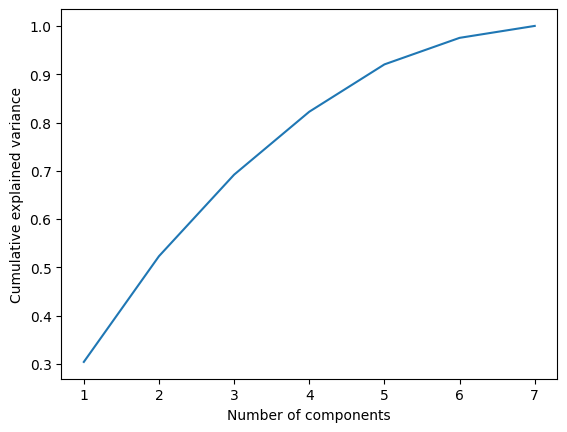

In [ ]:
# first plot the cumulative explained variance ratio
from sklearn.decomposition import PCA

df = grab_df[list(feature_mapping.values()) + thms_columns].copy()
df['TTHMs'] = df[thms_columns].sum(axis=1)
df = df[list(feature_mapping.values()) + ['TTHMs']]

# scale the data
scaler = MinMaxScaler()
df[list(feature_mapping.values())] = pd.DataFrame(scaler.fit_transform(df[list(feature_mapping.values())]), columns=list(feature_mapping.values()))

pca = PCA(n_components=len(list(feature_mapping.values())))
pca.fit(df[list(feature_mapping.values())])

plt.plot(range(1, len(list(feature_mapping.values())) + 1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

if we take 5 components, we explain more than 90% of the variance.

In [475]:
n_components = 5

df = grab_df[list(feature_mapping.values()) + thms_columns].copy()
df['TTHMs'] = df[thms_columns].sum(axis=1)
df = df[list(feature_mapping.values()) + ['TTHMs']]

# scale the data
scaler = MinMaxScaler()
df[list(feature_mapping.values())] = pd.DataFrame(scaler.fit_transform(df[list(feature_mapping.values())]), columns=list(feature_mapping.values()))

pca = PCA(n_components=n_components)
pca.fit(df[list(feature_mapping.values())])

df_pca = pca.fit_transform(df[list(feature_mapping.values())])
df_pca = pd.DataFrame(df_pca, columns=[f'PC{i}' for i in range(1, n_components + 1)])
df = pd.concat([df_pca, df['TTHMs']], axis=1)

print(pca.explained_variance_ratio_)


# perform Linear Regression with the principal components with cross-validation
lr = LinearRegression()
scores = cross_val_score(lr, df[[f'PC{i}' for i in range(1, n_components + 1)]], df['TTHMs'], cv=5, scoring='neg_mean_squared_error')
print("Validation MSE: ", -scores.mean())

[0.30429777 0.21893948 0.16881062 0.13030805 0.09799809]
Validation MSE:  5.480341680100535
